In [1]:
# =============================================================================
# RQ3: How do concept-based interventions influence cheating behavior, 
# performance, and experience through underlying psychological mechanisms?
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import sys, os, warnings

# Setup
os.chdir('game-behavior-analytics/data_analysis_notebook/')
sys.path.append(os.path.abspath('utils'))
warnings.filterwarnings('ignore')

from data_utils import load_and_prepare_data

# Load data
df, concepts = load_and_prepare_data("data/cheating_experiment_dataset.csv")

print("="*80)
print("RQ3: MECHANISM-BASED PREDICTION ANALYSIS ")
print("="*80)
print("RQ3.1: Mechanism vs Concept prediction of cheating behavior")
print("RQ3.2: Mechanism vs Concept prediction of performance by group")
print("RQ3.3: Mechanism vs Concept prediction of experience by group")
print("="*80)

RQ3: MECHANISM-BASED PREDICTION ANALYSIS 
RQ3.1: Mechanism vs Concept prediction of cheating behavior
RQ3.2: Mechanism vs Concept prediction of performance by group
RQ3.3: Mechanism vs Concept prediction of experience by group


In [11]:
# =============================================================================
# SETUP: Define mechanisms and prepare data
# =============================================================================

mechanisms = [
    'autonomy_need_satisfaction', 'autonomy_need_frustration',
    'competence_need_satisfaction', 'competence_need_frustration',
    'relatedness_need_satisfaction', 'relatedness_need_frustration',
    'cognitive_discomfort', 'moral_disengagement',
    'injunctive_norms', 'descriptive_norms', 'reference_group_identification', 'social_sanctions',
    'performance_accomplishments', 'vicarious_experience', 'verbal_persuasion', 'emotional_arousal'
]

mechanism_display_names = {
    'autonomy_need_satisfaction': 'Autonomy Need Satisfaction (SDM)',
    'autonomy_need_frustration': 'Autonomy Need Frustration (SDM)',
    'competence_need_satisfaction': 'Competence Need Satisfaction (SDM)',
    'competence_need_frustration': 'Competence Need Frustration (SDM)',
    'relatedness_need_satisfaction': 'Relatedness Need Satisfaction (SDM)',
    'relatedness_need_frustration': 'Relatedness Need Frustration (SDM)',
    'cognitive_discomfort': 'Cognitive Discomfort (CDM)',
    'moral_disengagement': 'Moral Disengagement (CDM)',
    'descriptive_norms': 'Perceived Descriptive Norms (SNM)',
    'injunctive_norms': 'Perceived Injunctive Norms (SNM)',
    'reference_group_identification': 'Perceived Reference Group Identification (SNM)',
    'social_sanctions': 'Perceived Social Sanctions (SNM)',
    'performance_accomplishments': 'Perceived Performance Accomplishments (SEM)',
    'vicarious_experience': 'Perceived Vicarious Experience (SEM)',
    'verbal_persuasion': 'Perceived Verbal Persuasion (SEM)',
    'emotional_arousal': 'Perceived Emotional Arousal (SEM)'
}

concept_mechanism_mapping = {
    'autonomy': ['autonomy_need_satisfaction', 'autonomy_need_frustration'],
    'competence': ['competence_need_satisfaction', 'competence_need_frustration'], 
    'relatedness': ['relatedness_need_satisfaction', 'relatedness_need_frustration'],
    'self_concept': ['cognitive_discomfort', 'moral_disengagement'],
    'cognitive_inconsistency': ['cognitive_discomfort', 'moral_disengagement'],
    'dissonance_arousal': ['cognitive_discomfort', 'moral_disengagement'], 
    'dissonance_reduction': ['cognitive_discomfort', 'moral_disengagement'],
    'performance_accomplishments': ['performance_accomplishments'],
    'vicarious_experience': ['vicarious_experience'],
    'verbal_persuasion': ['verbal_persuasion'],
    'emotional_arousal': ['emotional_arousal'],
    'descriptive_norms': ['descriptive_norms'],
    'injunctive_norms': ['injunctive_norms'],
    'social_sanctions': ['social_sanctions'],
    'reference_group_identification': ['reference_group_identification']
}

# Create reverse mapping
mechanism_concept_mapping = {}
for concept, mechs in concept_mechanism_mapping.items():
    for mech in mechs:
        mechanism_concept_mapping.setdefault(mech, []).append(concept)

# =============================================================================
# PREPARE DATA: Add intervention dummy and standardize covariates
# =============================================================================
# Calculate control baseline
control_data = df[df['concept'] == 'control']
control_means = control_data[mechanisms].mean()
control_performance = control_data['performance'].mean()
control_experience = control_data['experience'].mean()

# Create intervention dummy (0 = control, 1 = intervention)
df['intervention'] = (df['concept'] != 'control').astype(int)

# Check if perceived_ability exists
if 'perceived_ability' not in df.columns and 'word_creation_skill_level' in df.columns:
    df['perceived_ability'] = df['word_creation_skill_level']
    print("✓ Using 'word_creation_skill_level' as perceived_ability")

# Verify perceived_ability exists
if 'perceived_ability' not in df.columns:
    raise ValueError("perceived_ability not found in dataset. Check column names.")

# Standardize all continuous variables for modeling
scaler = StandardScaler()
df[mechanisms] = scaler.fit_transform(df[mechanisms])
df['perceived_ability_std'] = scaler.fit_transform(df[['perceived_ability']])

print(f"✓ Total participants: {len(df)}")
print(f"✓ Control: {(df['intervention']==0).sum()}, Intervention: {(df['intervention']==1).sum()}")
print(f"✓ Perceived ability range: {df['perceived_ability'].min():.1f} - {df['perceived_ability'].max():.1f}")
print(f"✓ Analyzing {len(mechanisms)} mechanisms")

✓ Total participants: 1232
✓ Control: 73, Intervention: 1159
✓ Perceived ability range: 1.0 - 10.0
✓ Analyzing 16 mechanisms


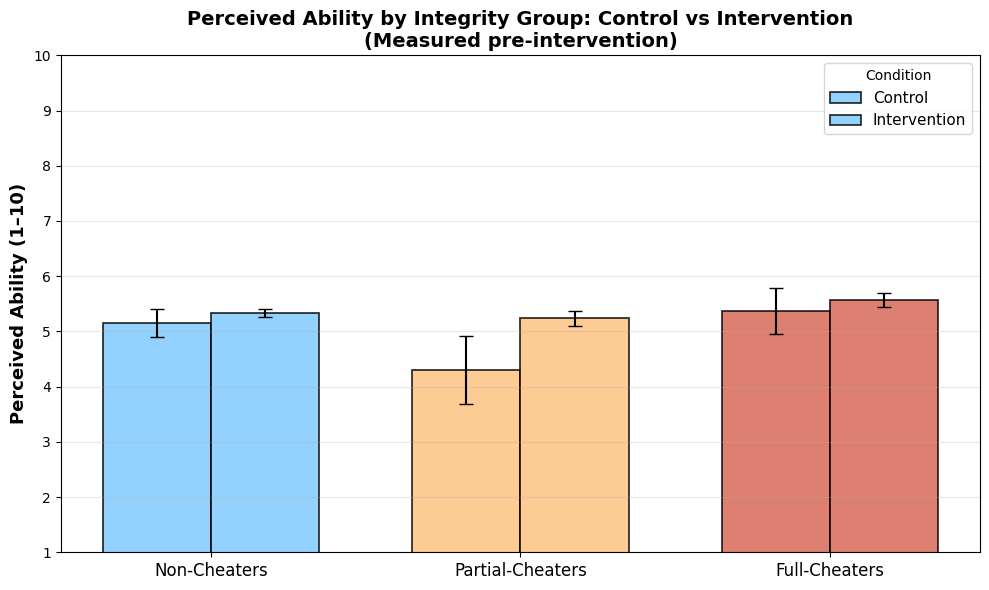


PERCEIVED ABILITY SUMMARY STATISTICS (Mean ± SD)
   Condition  Integrity Group Mean   SD  SEM   N
     Control     Non-Cheaters 5.15 1.57 0.25  39
     Control Partial-Cheaters 4.30 1.95 0.62  10
     Control    Full-Cheaters 5.38 2.04 0.42  24
Intervention     Non-Cheaters 5.33 1.79 0.07 734
Intervention Partial-Cheaters 5.24 1.98 0.14 203
Intervention    Full-Cheaters 5.56 1.91 0.13 222


In [12]:
# =============================================================================
# VISUALIZE PERCEIVED ABILITY BY INTEGRITY GROUP & CONDITION
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Prepare data
group_map = {0: 'Non-Cheaters', 1: 'Partial-Cheaters', 2: 'Full-Cheaters'}
colors = ['#78c6fe', '#fdbf7a', '#d6604d']
conditions = ['Control', 'Intervention']

fig, ax = plt.subplots(figsize=(10, 6))

# Calculate means and SEMs
x = np.arange(len(group_map))
width = 0.35

summary_rows = []  # for printing summary stats later

for i, (cond_name, cond_val) in enumerate([('Control', 0), ('Intervention', 1)]):
    means = []
    sems = []
    for g in group_map.keys():
        subset = df[(df['intervention'] == cond_val) & (df['cheating_behavior'] == g)]['perceived_ability']
        mean_val = subset.mean()
        sem_val = subset.sem()
        sd_val = subset.std()
        n_val = len(subset)
        means.append(mean_val)
        sems.append(sem_val)

        # store for summary printing
        summary_rows.append({
            'Condition': cond_name,
            'Integrity Group': group_map[g],
            'Mean': mean_val,
            'SD': sd_val,
            'SEM': sem_val,
            'N': n_val
        })

    ax.bar(x + i*width, means, width, yerr=sems, label=cond_name, 
           color=colors, alpha=0.8, capsize=5, edgecolor='black', linewidth=1.3)

# Axis formatting
ax.set_ylabel('Perceived Ability (1–10)', fontsize=13, fontweight='bold')
ax.set_title('Perceived Ability by Integrity Group: Control vs Intervention\n(Measured pre-intervention)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x + width/2)
ax.set_xticklabels(group_map.values(), fontsize=12)
ax.set_yticks(range(1, 11))
ax.set_ylim(1, 10)
ax.legend(title='Condition', fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# PRINT SUMMARY STATISTICS
# =============================================================================
summary_df = pd.DataFrame(summary_rows)
print("\n" + "="*70)
print("PERCEIVED ABILITY SUMMARY STATISTICS (Mean ± SD)")
print("="*70)
print(summary_df.to_string(index=False, 
      formatters={'Mean': '{:.2f}'.format, 'SD': '{:.2f}'.format, 'SEM': '{:.2f}'.format, 'N': '{:d}'.format}))


In [13]:
# =============================================================================
# UNIFIED PREDICTION FUNCTIONS WITH COVARIATE ADJUSTMENT
# =============================================================================

def calculate_partial_r2(X_full, X_reduced, y):
    """
    Calculate partial R² for variables in X_full but not in X_reduced.
    This shows unique variance explained by those variables.
    """
    if len(np.unique(y)) <= 1 or len(y) < 10:
        return 0, 0
    
    try:
        # Full model R²
        lr_full = LinearRegression().fit(X_full, y)
        r2_full = max(0, r2_score(y, lr_full.predict(X_full)))
        
        # Reduced model R²
        lr_reduced = LinearRegression().fit(X_reduced, y)
        r2_reduced = max(0, r2_score(y, lr_reduced.predict(X_reduced)))
        
        # Partial R² = improvement from adding the variable(s)
        partial_r2 = max(0, r2_full - r2_reduced)
        
        # Get coefficient of the mechanism (first variable in X_full if added one variable)
        coef = lr_full.coef_[0] if len(lr_full.coef_) > 0 else 0
        
        return partial_r2, coef
    except:
        return 0, 0


def calculate_mechanism_predictions(df, mechanisms, outcome_col, 
                                              target_type='continuous',
                                              groups_to_analyze=None):
    """
    Calculate mechanism predictions controlling for perceived_ability and intervention status.
    
    For continuous outcomes (performance, experience):
    - Model: outcome ~ intervention + perceived_ability + mechanism
    - Report partial R² for mechanism (controlling for covariates)
    
    For binary outcomes (cheating behavior):
    - Model: P(cheating_group) ~ intervention + perceived_ability + mechanism
    - Report pseudo-R² (McFadden) for mechanism contribution
    """
    
    if groups_to_analyze is None:
        groups_to_analyze = [(0, 'Non-Cheaters'), (1, 'Partial-Cheaters'), (2, 'Full-Cheaters')]
    
    results = {}
    
    for mechanism in mechanisms:
        if mechanism not in df.columns:
            continue
        
        results[mechanism] = {}
        
        if target_type == 'binary':
            # For cheating behavior: logistic regression for each target group
            for target_group, group_name in groups_to_analyze:
                # Select columns properly - mechanism is the variable name
                cols_to_select = [mechanism, 'perceived_ability_std', 'intervention', outcome_col]
                valid_data = df[cols_to_select].dropna()
                
                if len(valid_data) < 50:
                    results[mechanism][group_name] = {'r2': 0, 'coef': 0}
                    continue
                
                # Binarize outcome
                y_binary = (valid_data[outcome_col] == target_group).astype(int)
                
                # Reduced model: intervention + perceived_ability
                X_reduced = valid_data[['intervention', 'perceived_ability_std']].values
                
                # Full model: mechanism + perceived_ability + intervention
                # Note: mechanism is first column for coefficient extraction
                X_full = valid_data[[mechanism, 'perceived_ability_std', 'intervention']].values
                
                try:
                    # Logistic regression for reduced model
                    lr_reduced = LogisticRegression(max_iter=1000, random_state=42)
                    lr_reduced.fit(X_reduced, y_binary)
                    ll_reduced = lr_reduced.score(X_reduced, y_binary)
                    
                    # Logistic regression for full model
                    lr_full = LogisticRegression(max_iter=1000, random_state=42)
                    lr_full.fit(X_full, y_binary)
                    ll_full = lr_full.score(X_full, y_binary)
                    
                    # McFadden pseudo-R² for mechanism contribution
                    pseudo_r2 = max(0, ll_full - ll_reduced)
                    coef = lr_full.coef_[0][0]  # Coefficient for mechanism
                    
                    results[mechanism][group_name] = {'r2': pseudo_r2, 'coef': coef}
                except Exception as e:
                    print(f"Warning: Error fitting {mechanism} for {group_name}: {str(e)}")
                    results[mechanism][group_name] = {'r2': 0, 'coef': 0}
        
        else:
            # For continuous outcomes (performance, experience)
            for group_val, group_name in groups_to_analyze:
                group_data = df[df['cheating_behavior'] == group_val].copy()
                
                if len(group_data) < 30:
                    results[mechanism][group_name] = {'r2': 0, 'coef': 0}
                    continue
                
                cols_to_select = [mechanism, 'perceived_ability_std', 'intervention', outcome_col]
                valid_data = group_data[cols_to_select].dropna()
                
                if len(valid_data) < 20:
                    results[mechanism][group_name] = {'r2': 0, 'coef': 0}
                    continue
                
                # Reduced model: intervention + perceived_ability
                X_reduced = valid_data[['intervention', 'perceived_ability_std']].values
                
                # Full model: mechanism + perceived_ability + intervention
                X_full = valid_data[[mechanism, 'perceived_ability_std', 'intervention']].values
                
                y = valid_data[outcome_col].values
                
                partial_r2, coef = calculate_partial_r2(X_full, X_reduced, y)
                results[mechanism][group_name] = {'r2': partial_r2, 'coef': coef}
    
    return results


def calculate_concept_predictions(df, mechanism_concept_mapping,
                                           outcome_col, target_type='continuous'):
    """
    Calculate concept predictions controlling for perceived_ability.
    
    For each concept:
    - Compare participants who received that concept vs. others
    - Control for perceived_ability in the model
    """
    
    groups = [(0, 'Non-Cheaters'), (1, 'Partial-Cheaters'), (2, 'Full-Cheaters')]
    results = {}
    
    unique_concepts = set()
    for concepts_list in mechanism_concept_mapping.values():
        unique_concepts.update(concepts_list)
    
    # Create a copy to avoid modifying original df
    df_copy = df.copy()
    
    for concept in unique_concepts:
        # Create binary indicator for this concept
        df_copy['concept_received'] = (df_copy['concept'] == concept).astype(int)
        
        results[concept] = {}
        
        if target_type == 'binary':
            # For cheating behavior
            for target_group, group_name in groups:
                cols_to_select = ['concept_received', 'perceived_ability_std', outcome_col]
                valid_data = df_copy[cols_to_select].dropna()
                
                if len(valid_data) < 50:
                    results[concept][group_name] = {'r2': 0, 'coef': 0}
                    continue
                
                y_binary = (valid_data[outcome_col] == target_group).astype(int)
                
                # Reduced: perceived_ability only
                X_reduced = valid_data[['perceived_ability_std']].values
                
                # Full: concept + perceived_ability
                X_full = valid_data[['concept_received', 'perceived_ability_std']].values
                
                try:
                    lr_reduced = LogisticRegression(max_iter=1000, random_state=42)
                    lr_reduced.fit(X_reduced, y_binary)
                    ll_reduced = lr_reduced.score(X_reduced, y_binary)
                    
                    lr_full = LogisticRegression(max_iter=1000, random_state=42)
                    lr_full.fit(X_full, y_binary)
                    ll_full = lr_full.score(X_full, y_binary)
                    
                    pseudo_r2 = max(0, ll_full - ll_reduced)
                    coef = lr_full.coef_[0][0]
                    
                    results[concept][group_name] = {'r2': pseudo_r2, 'coef': coef}
                except Exception as e:
                    print(f"Warning: Error fitting {concept} for {group_name}: {str(e)}")
                    results[concept][group_name] = {'r2': 0, 'coef': 0}
        
        else:
            # For continuous outcomes
            for group_val, group_name in groups:
                group_data = df_copy[df_copy['cheating_behavior'] == group_val].copy()
                
                if len(group_data) < 30:
                    results[concept][group_name] = {'r2': 0, 'coef': 0}
                    continue
                
                cols_to_select = ['concept_received', 'perceived_ability_std', outcome_col]
                valid_data = group_data[cols_to_select].dropna()
                
                if len(valid_data) < 20:
                    results[concept][group_name] = {'r2': 0, 'coef': 0}
                    continue
                
                # Reduced: perceived_ability only
                X_reduced = valid_data[['perceived_ability_std']].values
                
                # Full: concept + perceived_ability
                X_full = valid_data[['concept_received', 'perceived_ability_std']].values
                
                y = valid_data[outcome_col].values
                
                partial_r2, coef = calculate_partial_r2(X_full, X_reduced, y)
                results[concept][group_name] = {'r2': partial_r2, 'coef': coef}
    
    return results

def display_results_table(mech_results, conc_results, mechanism_concept_mapping, 
                          mechanism_display_names, title, rq_num):
    """Display results table with proper formatting."""
    
    # Build display rows
    display_rows = []
    for mechanism in mech_results.keys():
        if mechanism in mechanism_concept_mapping:
            for parent_concept in mechanism_concept_mapping[mechanism]:
                display_rows.append((mechanism, parent_concept))
    
    # Display table
    print("\n" + "="*150)
    print(f"{title}")
    print("="*150)
    print(f"{'Mechanism':<45} {'Concept':<25} {'Non-Cheaters':<25} {'Partial-Cheaters':<25} {'Full-Cheaters':<25}")
    print(f"{'':45} {'':25} {'Mech R²':>11} {'Conc R²':>11} {'Mech R²':>11} {'Conc R²':>11} {'Mech R²':>11} {'Conc R²':>11}")
    print("-" * 150)
    
    def format_with_arrow(result):
        r2 = result.get('r2', 0)
        coef = result.get('coef', 0)
        arrow = "↑" if coef > 0 else "↓" if coef < 0 else ""
        return f"{r2*100:>10.2f}%{arrow}"
    
    for mechanism, parent_concept in display_rows:
        display_mech = mechanism_display_names.get(mechanism, mechanism.replace('_', ' ').title())
        display_concept = parent_concept.replace('_', ' ').title()
        
        mech_res = mech_results[mechanism]
        conc_res = conc_results.get(parent_concept, {
            'Non-Cheaters': {'r2': 0, 'coef': 0},
            'Partial-Cheaters': {'r2': 0, 'coef': 0},
            'Full-Cheaters': {'r2': 0, 'coef': 0}
        })
        
        nc_mech = format_with_arrow(mech_res.get('Non-Cheaters', {'r2': 0, 'coef': 0}))
        nc_conc = format_with_arrow(conc_res.get('Non-Cheaters', {'r2': 0, 'coef': 0}))
        pc_mech = format_with_arrow(mech_res.get('Partial-Cheaters', {'r2': 0, 'coef': 0}))
        pc_conc = format_with_arrow(conc_res.get('Partial-Cheaters', {'r2': 0, 'coef': 0}))
        fc_mech = format_with_arrow(mech_res.get('Full-Cheaters', {'r2': 0, 'coef': 0}))
        fc_conc = format_with_arrow(conc_res.get('Full-Cheaters', {'r2': 0, 'coef': 0}))
        
        print(f"{display_mech:<45} {display_concept:<25} {nc_mech:<12} {nc_conc:<12} {pc_mech:<12} {pc_conc:<12} {fc_mech:<12} {fc_conc:<12}")
    
    print("-" * 150)
    
    # Summary statistics
    all_mech_r2, all_conc_r2 = [], []
    better_mech_count = 0
    
    for mechanism, parent_concept in display_rows:
        mech_res = mech_results[mechanism]
        if parent_concept not in conc_results:
            continue
        conc_res = conc_results[parent_concept]
        
        for group in ['Non-Cheaters', 'Partial-Cheaters', 'Full-Cheaters']:
            mech_r2 = mech_res.get(group, {'r2': 0})['r2']
            conc_r2 = conc_res.get(group, {'r2': 0})['r2']
            all_mech_r2.append(mech_r2)
            all_conc_r2.append(conc_r2)
            if mech_r2 > conc_r2:
                better_mech_count += 1
    
    total = len(all_mech_r2)
    print("\nSUMMARY STATISTICS")
    print("-" * 150)
    print(f"Average Mechanism R²: {np.mean(all_mech_r2)*100:.2f}%")
    print(f"Average Concept R²: {np.mean(all_conc_r2)*100:.2f}%")
    print(f"Mechanisms outperform concepts: {better_mech_count}/{total} ({100*better_mech_count/total:.1f}%)")
    print(f"Mean improvement: {(np.mean(all_mech_r2) - np.mean(all_conc_r2))*100:+.2f} percentage points")
    print("\nNote: ↑ = positive relationship, ↓ = negative relationship")
    print(f"Note: All R² values are PARTIAL R² controlling for perceived_ability and intervention status")
    print(f"✓ {rq_num} Complete: Analyzed {len(display_rows)} mechanism-concept pairs\n")


In [5]:
# ===================================================================================================
# RQ3.1: Can mechanism changes predict cheating distribution (controlling for ability)?
# ===================================================================================================

print("\n" + "="*80)
print("RQ3.1: MECHANISM AND CONCEPT PREDICTION OF CHEATING BEHAVIOR")
print("(Controlling for perceived_ability and intervention status)")
print("="*80)

mech_cheat_results = calculate_mechanism_predictions(
    df, mechanisms, 'cheating_behavior', target_type='binary'
)

conc_cheat_results = calculate_concept_predictions(
    df, mechanism_concept_mapping, 'cheating_behavior', target_type='binary'
)

display_results_table(
    mech_cheat_results, conc_cheat_results, mechanism_concept_mapping,
    mechanism_display_names, 
    "MECHANISMS vs CONCEPTS: CHEATING BEHAVIOR PREDICTION (Partial R² controlling for ability)",
    "RQ3.1"
)


RQ3.1: MECHANISM AND CONCEPT PREDICTION OF CHEATING BEHAVIOR
(Controlling for perceived_ability and intervention status)

MECHANISMS vs CONCEPTS: CHEATING BEHAVIOR PREDICTION (Partial R² controlling for ability)
Mechanism                                     Concept                   Non-Cheaters              Partial-Cheaters          Full-Cheaters            
                                                                            Mech R²     Conc R²     Mech R²     Conc R²     Mech R²     Conc R²
------------------------------------------------------------------------------------------------------------------------------------------------------
Autonomy Need Satisfaction (SDM)              Autonomy                        0.08%↓       0.00%↑       0.00%↑       0.00%↑       0.00%↑       0.00%↓
Autonomy Need Frustration (SDM)               Autonomy                        0.00%↑       0.00%↑       0.00%↓       0.00%↑       0.00%↑       0.00%↓
Competence Need Satisfaction (SDM)        

In [14]:
# ===================================================================================================
# RQ3.2: Can mechanisms predict performance (controlling for ability)?
# ===================================================================================================

print("\n" + "="*80)
print("RQ3.2: MECHANISM AND CONCEPT PREDICTION OF PERFORMANCE")
print("(Controlling for perceived_ability and intervention status)")
print("="*80)

mech_perf_results = calculate_mechanism_predictions(
    df, mechanisms, 'performance', target_type='continuous'
)

conc_perf_results = calculate_concept_predictions(
    df, mechanism_concept_mapping, 'performance', target_type='continuous'
)

display_results_table(
    mech_perf_results, conc_perf_results, mechanism_concept_mapping,
    mechanism_display_names,
    "MECHANISMS vs CONCEPTS: PERFORMANCE PREDICTION (Partial R² controlling for ability)",
    "RQ3.2"
)


RQ3.2: MECHANISM AND CONCEPT PREDICTION OF PERFORMANCE
(Controlling for perceived_ability and intervention status)

MECHANISMS vs CONCEPTS: PERFORMANCE PREDICTION (Partial R² controlling for ability)
Mechanism                                     Concept                   Non-Cheaters              Partial-Cheaters          Full-Cheaters            
                                                                            Mech R²     Conc R²     Mech R²     Conc R²     Mech R²     Conc R²
------------------------------------------------------------------------------------------------------------------------------------------------------
Autonomy Need Satisfaction (SDM)              Autonomy                        1.62%↑       0.00%↑       0.23%↑       0.01%↓       2.92%↑       0.19%↓
Autonomy Need Frustration (SDM)               Autonomy                        5.32%↓       0.00%↑       3.11%↓       0.01%↓       1.89%↓       0.19%↓
Competence Need Satisfaction (SDM)            Competen

In [15]:
# ===================================================================================================
# RQ3.3: Can mechanisms predict experience (controlling for ability)?
# ===================================================================================================

print("\n" + "="*80)
print("RQ3.3: MECHANISM AND CONCEPT PREDICTION OF EXPERIENCE")
print("(Controlling for perceived_ability and intervention status)")
print("="*80)

mech_exp_results = calculate_mechanism_predictions(
    df, mechanisms, 'experience', target_type='continuous'
)

conc_exp_results = calculate_concept_predictions(
    df, mechanism_concept_mapping, 'experience', target_type='continuous'
)

display_results_table(
    mech_exp_results, conc_exp_results, mechanism_concept_mapping,
    mechanism_display_names,
    "MECHANISMS vs CONCEPTS: EXPERIENCE PREDICTION (Partial R² controlling for ability)",
    "RQ3.3"
)

print("\n" + "="*80)
print("✓ RQ3 ANALYSIS COMPLETE")
print("="*80)
print("Key methodological improvements:")
print("1. Proper between-subjects design (no invalid 'delta' calculations)")
print("2. Controlled for perceived_ability (measured pre-intervention)")
print("3. Controlled for intervention status in all models")
print("4. Reported partial R² (unique variance explained by mechanisms)")
print("5. Individual-level modeling (not group mean comparisons)")
print("="*80)


RQ3.3: MECHANISM AND CONCEPT PREDICTION OF EXPERIENCE
(Controlling for perceived_ability and intervention status)

MECHANISMS vs CONCEPTS: EXPERIENCE PREDICTION (Partial R² controlling for ability)
Mechanism                                     Concept                   Non-Cheaters              Partial-Cheaters          Full-Cheaters            
                                                                            Mech R²     Conc R²     Mech R²     Conc R²     Mech R²     Conc R²
------------------------------------------------------------------------------------------------------------------------------------------------------
Autonomy Need Satisfaction (SDM)              Autonomy                        9.86%↑       0.00%↓      10.96%↑       0.03%↑      11.84%↑       0.07%↑
Autonomy Need Frustration (SDM)               Autonomy                        2.90%↓       0.00%↓       2.68%↓       0.03%↑       2.03%↓       0.07%↑
Competence Need Satisfaction (SDM)            Competence


GENERATING INTEGRATED THREE-COMPARTMENT VISUALIZATION


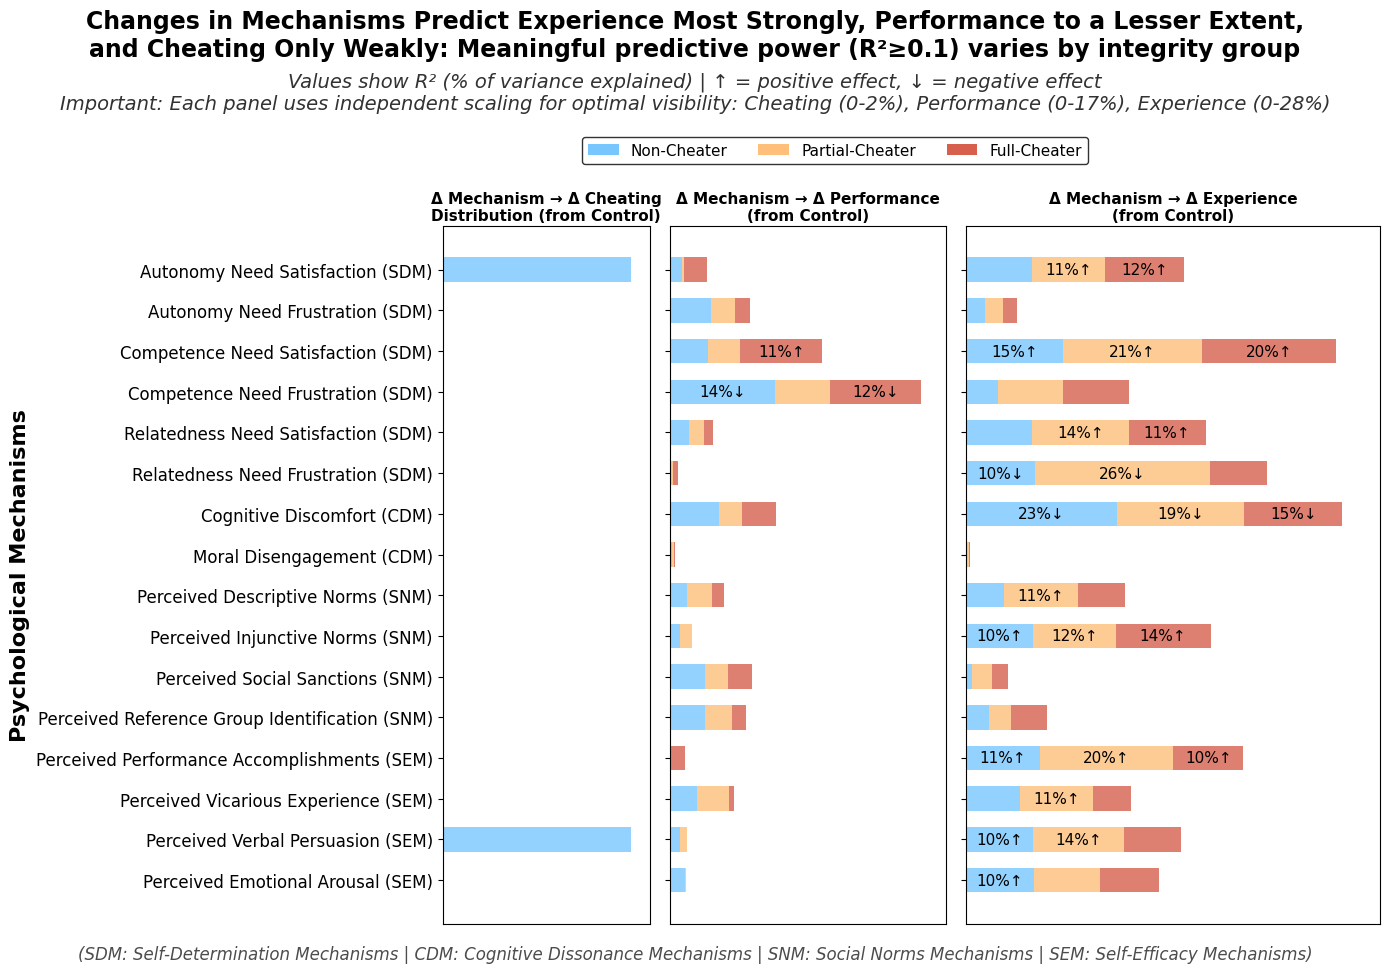

In [16]:
# =============================================================================
# RQ3 COMPLETE VISUALIZATION: Integrated Three-Compartment Analysis
# =============================================================================

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

# =============================================================================
# STEP 1: Add direction information to all results
# =============================================================================

def add_direction_to_results(results):
    """Add direction field based on coefficient sign"""
    enhanced_results = {}
    for mechanism, groups in results.items():
        enhanced_results[mechanism] = {}
        for group, data in groups.items():
            r2 = data.get('r2', 0)
            coef = data.get('coef', 0)
            if coef > 0:
                direction = 'positive'
            elif coef < 0:
                direction = 'negative'
            else:
                direction = 'none'
            enhanced_results[mechanism][group] = {
                'r2': r2,
                'coef': coef,
                'direction': direction
            }
    return enhanced_results

# Add direction information to all results
cheating_results = add_direction_to_results(mech_cheat_results)
performance_results = add_direction_to_results(mech_perf_results)
experience_results = add_direction_to_results(mech_exp_results)


# =============================================================================
# STEP 2: Create integrated three-compartment visualization
# =============================================================================

def create_integrated_visualization(cheating_results, perf_results, exp_results, 
                                    mechanism_order, display_names):
    """
    Create a three-compartment horizontal stacked bar chart
    Compartment 1: Cheating Behavior Prediction
    Compartment 2: Performance Prediction by Cheating Group  
    Compartment 3: Experience Prediction by Cheating Group
    """
    
    # Prepare data for all three compartments
    def prepare_compartment_data(results, keys):
        """Extract R² and direction for each mechanism-key pair"""
        data = {}
        direction_data = {}
        
        for mech in mechanism_order:
            if mech not in results:
                continue
            name = display_names.get(mech, mech.replace('_', ' ').title())
            data[name] = {}
            
            for key in keys:
                result = results[mech].get(key, {'r2': 0, 'coef': 0, 'direction': 'none'})
                if isinstance(result, dict):
                    data[name][key] = result['r2']
                    direction_data[(name, key)] = result['direction']
                else:
                    data[name][key] = result
                    direction_data[(name, key)] = 'none'
        
        return data, direction_data
    
    # Define groups and colors for each compartment
    cheat_groups = ['Non-Cheaters', 'Partial-Cheaters', 'Full-Cheaters']
    bar_colors = {
        'Non-Cheaters': "#78c6fe",
        'Partial-Cheaters': '#fdbf7a', 
        'Full-Cheaters': '#d6604d'
    }
    
    # Prepare data for each compartment
    cheat_data, cheat_directions = prepare_compartment_data(cheating_results, cheat_groups)
    perf_data, perf_directions = prepare_compartment_data(perf_results, cheat_groups)
    exp_data, exp_directions = prepare_compartment_data(exp_results, cheat_groups)
    
    # Get mechanism names in order (filter to only those with data)
    mech_names = [display_names.get(m, m.replace('_', ' ').title()) 
                  for m in mechanism_order if m in cheating_results]
    
    # Create figure with three subplots side by side
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 10), sharey=True, 
                                     gridspec_kw={'width_ratios': [1.5, 2, 3]})
    
    y_pos = np.arange(len(mech_names))
    bar_height = 0.6
    
    # Helper function to plot compartment
    def plot_compartment(ax, data, directions, groups, colors, title, 
                        show_border=False, r2_threshold=0.01):
        left_positions = np.zeros(len(mech_names))
        
        for group in groups:
            vals = np.array([data.get(name, {}).get(group, 0) for name in mech_names])
            bars = ax.barh(y_pos, vals, left=left_positions, height=bar_height,
                          color=colors[group], alpha=0.8, edgecolor='none')
            
            # Add border for performance compartment
            if show_border:
                for bar in bars:
                    if bar.get_width() > 0:
                        ax.barh(bar.get_y() + 0.3, bar.get_width(), height=bar.get_height(),
                               left=bar.get_x(), facecolor="none", edgecolor="black", 
                               linewidth=2, alpha=1, zorder=2)
            
            # Add value labels with direction
            for i, (bar, val) in enumerate(zip(bars, vals)):
                if val >= r2_threshold:
                    mechanism_name = mech_names[i]
                    direction = directions.get((mechanism_name, group), 'none')
                    direction_symbol = "↑" if direction == 'positive' else "↓" if direction == 'negative' else ""
                    text = f'{val*100:.0f}%{direction_symbol}'
                    ax.text(left_positions[i] + val/2, bar.get_y() + bar.get_height()/2,
                           text, ha='center', va='center', fontsize=11)
            
            left_positions += vals
        
        ax.set_title(title, fontsize=11, fontweight='bold', pad=4)
        # ax.grid(True, axis='x', alpha=0.3)
        ax.set_xlim(0, max(left_positions)*1.1 if max(left_positions) > 0 else 0.1)
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        
        return ax
    
    # Plot each compartment
    plot_compartment(ax1, cheat_data, cheat_directions, cheat_groups, bar_colors,
                    'Δ Mechanism → Δ Cheating\nDistribution (from Control)', r2_threshold=0.01)
    plot_compartment(ax2, perf_data, perf_directions, cheat_groups, bar_colors,
                    'Δ Mechanism → Δ Performance\n(from Control)', show_border=False, r2_threshold=0.1)
    plot_compartment(ax3, exp_data, exp_directions, cheat_groups, bar_colors,
                    'Δ Mechanism → Δ Experience\n(from Control)', r2_threshold=0.1)
    
    # Set y-axis labels only on the leftmost plot
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(mech_names, fontsize=12)
    ax1.set_ylabel('Psychological Mechanisms', fontsize=16, fontweight='bold')
    
    # Create unified legend
    legend_elements = [
        mpatches.Patch(facecolor=bar_colors['Non-Cheaters'], label='Non-Cheater'),
        mpatches.Patch(facecolor=bar_colors['Partial-Cheaters'], label='Partial-Cheater'),
        mpatches.Patch(facecolor=bar_colors['Full-Cheaters'], label='Full-Cheater'),
    ]
    
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.6, 0.84),
              ncol=3, fontsize=11, frameon=True, facecolor='white', edgecolor='black')
    
    # Main title and subtitle
    fig.suptitle('Changes in Mechanisms Predict Experience Most Strongly, Performance to a Lesser Extent,\n'
                 'and Cheating Only Weakly: Meaningful predictive power (R²≥0.1) varies by integrity group',
                fontsize=17, fontweight='bold', y=0.96)
    fig.text(0.5, 0.86, 
        'Values show R² (% of variance explained) | ↑ = positive effect, ↓ = negative effect\n'
        'Important: Each panel uses independent scaling for optimal visibility: Cheating (0-2%), Performance (0-17%), Experience (0-28%)',
        ha='center', fontsize=14, fontstyle='italic', color="#323232")
    
    fig.text(
        0.5, 0.01,
        "(SDM: Self-Determination Mechanisms | CDM: Cognitive Dissonance Mechanisms | "
        "SNM: Social Norms Mechanisms | SEM: Self-Efficacy Mechanisms)",
        ha='center',
        fontsize=12,
        fontstyle='italic',
        color='black',
        alpha=0.7
    )
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.86])
    plt.show()

# =============================================================================
# STEP 3: Execute visualization
# =============================================================================

print("\n" + "="*80)
print("GENERATING INTEGRATED THREE-COMPARTMENT VISUALIZATION")
print("="*80)

# Mechanism display order (reversed for bottom-to-top display)
mechanism_order = [
    'autonomy_need_satisfaction', 'autonomy_need_frustration',
    'competence_need_satisfaction', 'competence_need_frustration',
    'relatedness_need_satisfaction', 'relatedness_need_frustration',
    'cognitive_discomfort', 'moral_disengagement',
    'descriptive_norms', 'injunctive_norms',
    'social_sanctions', 'reference_group_identification',
    'performance_accomplishments', 'vicarious_experience',
    'verbal_persuasion', 'emotional_arousal'
][::-1]

# Create the integrated visualization
create_integrated_visualization(
    cheating_results, 
    performance_results,
    experience_results,
    mechanism_order,
    mechanism_display_names
)




ANALYZING PERCEIVED OUTCOMES - SAME APPROACH AS ACTUAL OUTCOMES
Control Perceived Outcome baselines (for reference):
  Perceived Honesty: 2.98
  Perceived Performance: 4.08
  Perceived Experience: 4.70

GENERATING PERCEIVED OUTCOMES THREE-COMPARTMENT VISUALIZATION


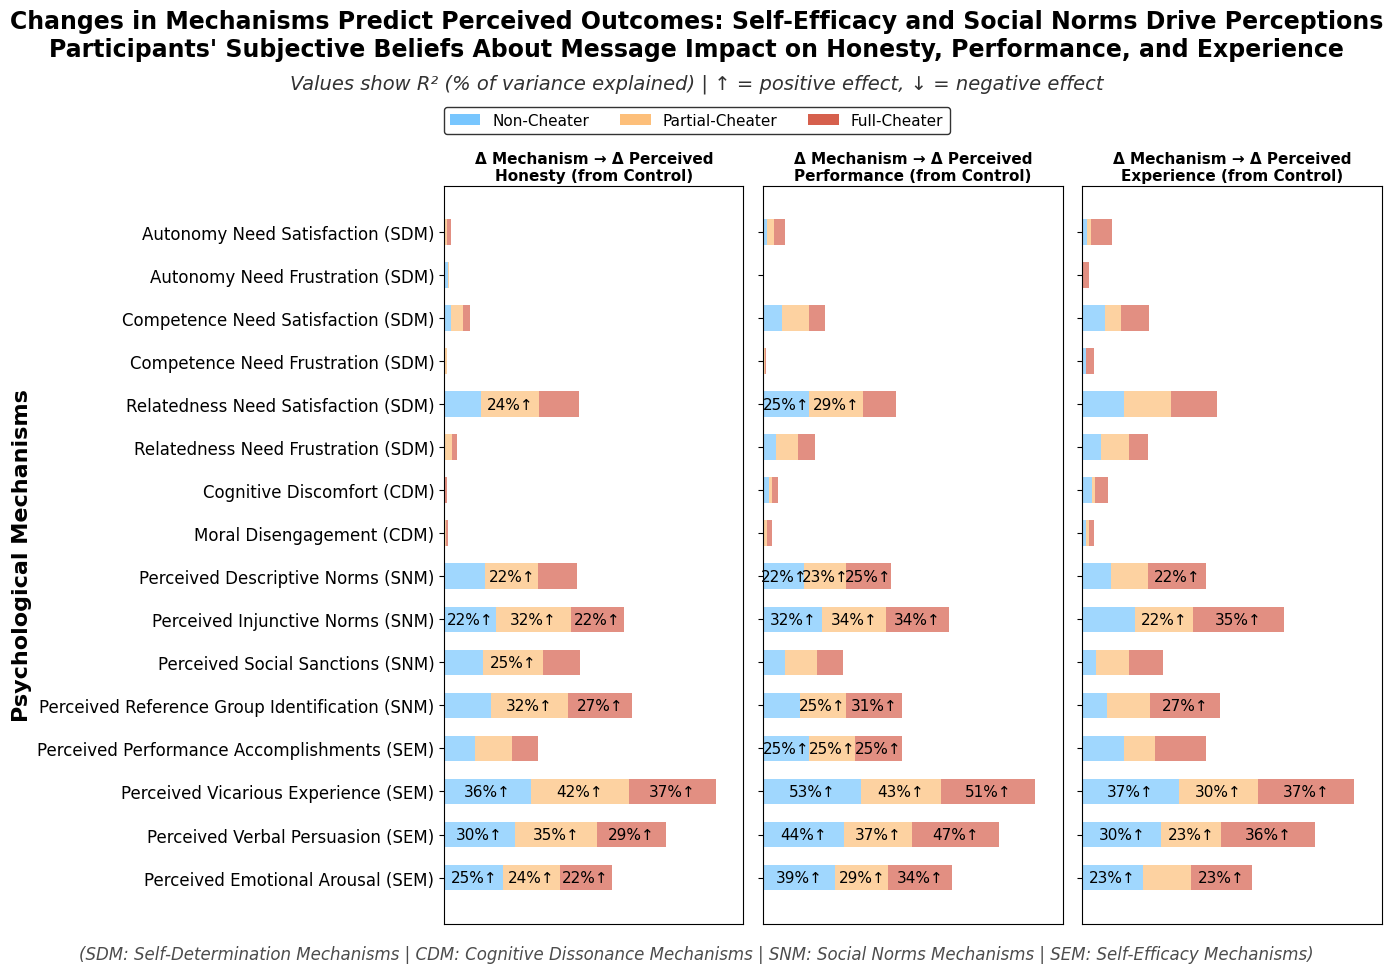


CREATING CSV WITH R² VALUES FOR PERCEIVED OUTCOMES

✓ CSV created: pme_r2_values.csv
  Total rows: 48
  Columns: Outcome, Mechanism, Non-Cheaters, Partial-Cheaters, Full-Cheaters

✓ Perceived outcomes analysis complete!


In [22]:
# =============================================================================
# RQ3 PERCEIVED OUTCOMES VISUALIZATION: Integrated Three-Compartment Analysis
# =============================================================================

print("\n" + "="*80)
print("ANALYZING PERCEIVED OUTCOMES - SAME APPROACH AS ACTUAL OUTCOMES")
print("="*80)

# Calculate control baselines for perceived outcomes (for reference/logging only)
pme_control_data = df[df['concept'] == 'control']
pme_control_means = {
    'perceived_honesty': pme_control_data['perceived_honesty'].mean(),
    'perceived_performance': pme_control_data['perceived_performance'].mean(),
    'perceived_experience': pme_control_data['perceived_experience'].mean()
}

print(f"Control Perceived Outcome baselines (for reference):")
print(f"  Perceived Honesty: {pme_control_means['perceived_honesty']:.2f}")
print(f"  Perceived Performance: {pme_control_means['perceived_performance']:.2f}")
print(f"  Perceived Experience: {pme_control_means['perceived_experience']:.2f}")

# Calculate mechanism predictions for perceived outcomes
# NOTE: The function now controls for perceived_ability and intervention status internally
# No need to pass control_means or baseline values
pme_honesty_results = calculate_mechanism_predictions(
    df, mechanisms, 'perceived_honesty', target_type='continuous'
)

pme_perf_results = calculate_mechanism_predictions(
    df, mechanisms, 'perceived_performance', target_type='continuous'
)

pme_exp_results = calculate_mechanism_predictions(
    df, mechanisms, 'perceived_experience', target_type='continuous'
)

# Add direction information
pme_honesty_results = add_direction_to_results(pme_honesty_results)
pme_perf_results = add_direction_to_results(pme_perf_results)
pme_exp_results = add_direction_to_results(pme_exp_results)

# Create custom visualization with equal width ratios
def create_pme_visualization(honesty_results, perf_results, exp_results, 
                             mechanism_order, display_names):
    """Create three-compartment visualization for perceived outcomes with equal widths"""
    
    # Prepare data (same as before)
    def prepare_compartment_data(results, keys):
        data = {}
        direction_data = {}
        
        for mech in mechanism_order:
            if mech not in results:
                continue
            name = display_names.get(mech, mech.replace('_', ' ').title())
            data[name] = {}
            
            for key in keys:
                result = results[mech].get(key, {'r2': 0, 'coef': 0, 'direction': 'none'})
                if isinstance(result, dict):
                    data[name][key] = result['r2']
                    direction_data[(name, key)] = result['direction']
                else:
                    data[name][key] = result
                    direction_data[(name, key)] = 'none'
        
        return data, direction_data
    
    # Define groups and colors
    cheat_groups = ['Non-Cheaters', 'Partial-Cheaters', 'Full-Cheaters']
    bar_colors = {
        'Non-Cheaters': "#78c6fe",
        'Partial-Cheaters': '#fdbf7a', 
        'Full-Cheaters': '#d6604d'
    }
    
    # Prepare data for each compartment
    honesty_data, honesty_directions = prepare_compartment_data(honesty_results, cheat_groups)
    perf_data, perf_directions = prepare_compartment_data(perf_results, cheat_groups)
    exp_data, exp_directions = prepare_compartment_data(exp_results, cheat_groups)
    
    # Get mechanism names in order
    mech_names = [display_names.get(m, m.replace('_', ' ').title()) 
                  for m in mechanism_order if m in honesty_results]
    
    # Create figure with three equal-width subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 10), sharey=True, 
                                        gridspec_kw={'width_ratios': [1, 1, 1]})
    
    y_pos = np.arange(len(mech_names))
    bar_height = 0.6
    
    # Helper function to plot compartment
    def plot_compartment(ax, data, directions, groups, colors, title, r2_threshold=0.01):
        left_positions = np.zeros(len(mech_names))
        
        for group in groups:
            vals = np.array([data.get(name, {}).get(group, 0) for name in mech_names])
            bars = ax.barh(y_pos, vals, left=left_positions, height=bar_height,
                          color=[colors[group]]*len(mech_names), alpha=0.7)
            
            # Add R² text and direction arrows for significant values
            for i, (bar, val) in enumerate(zip(bars, vals)):
                if val >= r2_threshold:
                    direction = directions.get((mech_names[i], group), 'none')
                    arrow = '↑' if direction == 'positive' else '↓' if direction == 'negative' else ''
                    text = f'{val:.0%}{arrow}'
                    ax.text(left_positions[i] + val/2, bar.get_y() + bar.get_height()/2,
                           text, ha='center', va='center', fontsize=11)
            
            left_positions += vals
        
        ax.set_title(title, fontsize=11, fontweight='bold', pad=4)
        ax.set_xlim(0, max(left_positions)*1.1 if max(left_positions) > 0 else 0.1)
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        
        return ax
    
    # Plot all three compartments
    plot_compartment(ax1, honesty_data, honesty_directions, cheat_groups, bar_colors,
                    'Δ Mechanism → Δ Perceived\nHonesty (from Control)', r2_threshold=0.2)
    plot_compartment(ax2, perf_data, perf_directions, cheat_groups, bar_colors,
                    'Δ Mechanism → Δ Perceived\nPerformance (from Control)', r2_threshold=0.2)
    plot_compartment(ax3, exp_data, exp_directions, cheat_groups, bar_colors,
                    'Δ Mechanism → Δ Perceived\nExperience (from Control)', r2_threshold=0.2)
    
    # Y-axis labels
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(mech_names, fontsize=12)
    ax1.set_ylabel('Psychological Mechanisms', fontsize=16, fontweight='bold')
    
    # Legend
    legend_elements = [
        mpatches.Patch(facecolor=bar_colors['Non-Cheaters'], label='Non-Cheater'),
        mpatches.Patch(facecolor=bar_colors['Partial-Cheaters'], label='Partial-Cheater'),
        mpatches.Patch(facecolor=bar_colors['Full-Cheaters'], label='Full-Cheater'),
    ]
    
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.87),
              ncol=3, fontsize=11, frameon=True, facecolor='white', edgecolor='black')
    
    # Titles
    fig.suptitle('Changes in Mechanisms Predict Perceived Outcomes: Self-Efficacy and Social Norms Drive Perceptions\n'
                 'Participants\' Subjective Beliefs About Message Impact on Honesty, Performance, and Experience',
                fontsize=17, fontweight='bold', y=0.96)
    fig.text(0.5, 0.88, 
            'Values show R² (% of variance explained) | ↑ = positive effect, ↓ = negative effect',
            ha='center', fontsize=14, fontstyle='italic', color="#323232")
    
    fig.text(0.5, 0.01,
            "(SDM: Self-Determination Mechanisms | CDM: Cognitive Dissonance Mechanisms | "
            "SNM: Social Norms Mechanisms | SEM: Self-Efficacy Mechanisms)",
            ha='center', fontsize=12, fontstyle='italic', color='black', alpha=0.7)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.90])
    plt.show()

# =============================================================================
# STEP 3: Execute visualization
# =============================================================================

print("\n" + "="*80)
print("GENERATING PERCEIVED OUTCOMES THREE-COMPARTMENT VISUALIZATION")
print("="*80)

# Create the visualization
create_pme_visualization(
    pme_honesty_results,
    pme_perf_results,
    pme_exp_results,
    mechanism_order,  # This was defined earlier in the script
    mechanism_display_names  # This was defined earlier in the script
)

# =============================================================================
# CREATE CSV WITH R² VALUES FOR PERCEIVED OUTCOMES (SIMPLIFIED)
# =============================================================================

print("\n" + "="*80)
print("CREATING CSV WITH R² VALUES FOR PERCEIVED OUTCOMES")
print("="*80)

def create_pme_r2_csv_simple(honesty_results, perf_results, exp_results, 
                              mechanism_display_names):
    """
    Create CSV with R² values for perceived outcomes organized by:
    Outcome | Mechanism | Non-Cheaters | Partial-Cheaters | Full-Cheaters
    """
    
    all_rows = []
    
    # Process each outcome type
    outcomes = {
        'Perceived Honesty': honesty_results,
        'Perceived Performance': perf_results,
        'Perceived Experience': exp_results
    }
    
    for outcome_name, results in outcomes.items():
        for mechanism, group_data in results.items():
            # Get display name for mechanism
            display_mech = mechanism_display_names.get(mechanism, 
                                                       mechanism.replace('_', ' ').title())
            
            # Extract R² values for each group
            row = {
                'Outcome': outcome_name,
                'Mechanism': display_mech,
                'Non-Cheaters': group_data.get('Non-Cheaters', {}).get('r2', 0),
                'Partial-Cheaters': group_data.get('Partial-Cheaters', {}).get('r2', 0),
                'Full-Cheaters': group_data.get('Full-Cheaters', {}).get('r2', 0)
            }
            
            all_rows.append(row)
    
    # Create DataFrame
    df_r2 = pd.DataFrame(all_rows)
    
    # Sort by outcome, then mechanism
    df_r2 = df_r2.sort_values(['Outcome', 'Mechanism']).reset_index(drop=True)
    
    return df_r2

# Create the CSV
pme_r2_df = create_pme_r2_csv_simple(
    pme_honesty_results,
    pme_perf_results,
    pme_exp_results,
    mechanism_display_names
)

# Save to CSV
output_filename = 'pme_r2_values.csv'
pme_r2_df.to_csv(output_filename, index=False)

print(f"\n✓ CSV created: {output_filename}")
print(f"  Total rows: {len(pme_r2_df)}")
print(f"  Columns: {', '.join(pme_r2_df.columns)}")
print("\n✓ Perceived outcomes analysis complete!")


=== Average R² per Group × Outcome ===
Non-Cheaters:
  Change in Cheating
Distribution from Control: Mechanisms R² = 0.01% | Concepts R² = 0.00%
  Change in Performance
from Control: Mechanisms R² = 3.40% | Concepts R² = 0.17%
  Change in Experience
from Control: Mechanisms R² = 8.44% | Concepts R² = 0.07%

Partial-Cheaters:
  Change in Cheating
Distribution from Control: Mechanisms R² = 0.00% | Concepts R² = 0.00%
  Change in Performance
from Control: Mechanisms R² = 2.27% | Concepts R² = 0.27%
  Change in Experience
from Control: Mechanisms R² = 11.70% | Concepts R² = 0.50%

Full-Cheaters:
  Change in Cheating
Distribution from Control: Mechanisms R² = 0.00% | Concepts R² = 0.00%
  Change in Performance
from Control: Mechanisms R² = 2.65% | Concepts R² = 0.19%
  Change in Experience
from Control: Mechanisms R² = 8.82% | Concepts R² = 0.35%



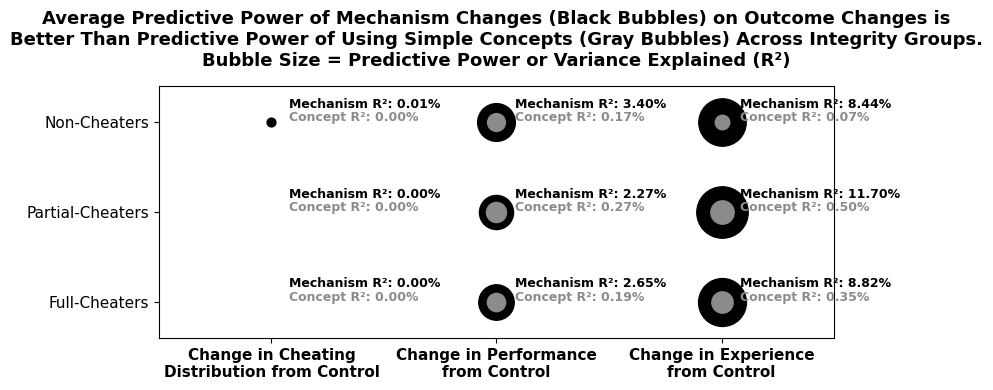

In [23]:
#=========================================================================
# Comparison of Mechanisms vs Concepts Prediction Accuracy To Outcomes
#=========================================================================

import matplotlib.pyplot as plt
import numpy as np

def prepare_avg_r2(mech_results, conc_results):
    """Return dicts with average R² across mechanisms and concepts for each group × outcome."""
    groups = ['Non-Cheaters', 'Partial-Cheaters', 'Full-Cheaters']
    
    mech_matrix = {g: [] for g in groups}
    conc_matrix = {g: [] for g in groups}
    
    for m, g_data in mech_results.items():
        for g in groups:
            mech_matrix[g].append(g_data.get(g, {}).get('r2', 0))
    for c, g_data in conc_results.items():
        for g in groups:
            conc_matrix[g].append(g_data.get(g, {}).get('r2', 0))
    
    mech_avg = {g: np.mean(mech_matrix[g]) for g in groups}
    conc_avg = {g: np.mean(conc_matrix[g]) for g in groups}
    
    return mech_avg, conc_avg


def create_bubble_matrix_comparison(mech_cheat_results, conc_cheat_results,
                                    mech_perf_results, conc_perf_results,
                                    mech_exp_results, conc_exp_results):
    fig, ax = plt.subplots(figsize=(9, 4))
    
    outcomes = [
        'Change in Cheating\nDistribution from Control', 
        'Change in Performance\nfrom Control', 
        'Change in Experience\nfrom Control'
    ]
    groups = ['Non-Cheaters', 'Partial-Cheaters', 'Full-Cheaters']
    
    # --- Collect average R² values automatically ---
    mech_cheat, conc_cheat = prepare_avg_r2(mech_cheat_results, conc_cheat_results)
    mech_perf,  conc_perf  = prepare_avg_r2(mech_perf_results, conc_perf_results)
    mech_exp,   conc_exp   = prepare_avg_r2(mech_exp_results, conc_exp_results)
    
    mechanisms_data = {
        'Change in Cheating\nDistribution from Control': [mech_cheat[g] for g in groups],
        'Change in Performance\nfrom Control': [mech_perf[g] for g in groups],
        'Change in Experience\nfrom Control': [mech_exp[g] for g in groups]
    }
    
    concepts_data = {
        'Change in Cheating\nDistribution from Control': [conc_cheat[g] for g in groups],
        'Change in Performance\nfrom Control': [conc_perf[g] for g in groups],
        'Change in Experience\nfrom Control': [conc_exp[g] for g in groups]
    }
    
    # --- Print average R² per group × outcome ---
    print("\n=== Average R² per Group × Outcome ===")
    for j, g in enumerate(groups):
        print(f"{g}:")
        for outcome in outcomes:
            mech_r2 = mechanisms_data[outcome][j] * 100
            conc_r2 = concepts_data[outcome][j] * 100
            print(f"  {outcome.replace('\\n', ' ')}: Mechanisms R² = {mech_r2:.2f}% | Concepts R² = {conc_r2:.2f}%")
        print("")  # blank line between groups

    # --- Reverse groups for plotting (so Non-Cheaters appear on top) ---
    groups_plot = groups[::-1]
    y_pos = np.arange(len(groups_plot))
    x_pos = np.arange(len(outcomes))
    
    # --- Plot bubbles ---
    for i, outcome in enumerate(outcomes):
        for j, group in enumerate(groups):
            mech_r2 = mechanisms_data[outcome][j]
            conc_r2 = concepts_data[outcome][j]
            
            mech_size = np.sqrt(mech_r2) * 4000
            conc_size = np.sqrt(conc_r2) * 4000 if conc_r2 > 0 else 0
            
            # Mechanism bubble
            ax.scatter(x_pos[i], len(groups)-1-j, s=mech_size, color="#000000")
            
            # Concept bubble (inside)
            if conc_r2 > 0:
                ax.scatter(x_pos[i], len(groups)-1-j, s=conc_size, color="#8B8B8B")
            
            # Add text with R² values beside bubble
            ax.text(x_pos[i] + 0.08, len(groups)-1-j + 0.2,
                    f"Mechanism R²: {mech_r2*100:.2f}%", color="#000000",
                    ha='left', va='center', fontsize=9, fontweight='bold')
            ax.text(x_pos[i] + 0.08, len(groups)-1-j + 0.05,
                    f"Concept R²: {conc_r2*100:.2f}%", color="#8B8B8B",
                    ha='left', va='center', fontsize=9, fontweight='bold')
    
    # --- Styling ---
    ax.set_xticks(x_pos)
    ax.set_xticklabels(outcomes, fontsize=11, fontweight='bold')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(groups_plot, fontsize=11)
    
    ax.set_xlim(-0.5, len(outcomes) - 0.5)
    ax.set_ylim(-0.4, len(groups_plot) - 0.6)
    ax.set_axisbelow(True)
    
    ax.set_title(
        "Average Predictive Power of Mechanism Changes (Black Bubbles) on Outcome Changes is\n"
        "Better Than Predictive Power of Using Simple Concepts (Gray Bubbles) Across Integrity Groups.\n"
        "Bubble Size = Predictive Power or Variance Explained (R²)",
        fontsize=13, fontweight='bold', pad=15
    )

    plt.tight_layout()
    plt.show()


# =============================================================================
# Run the visualization
# =============================================================================
create_bubble_matrix_comparison(
    mech_cheat_results, conc_cheat_results,
    mech_perf_results, conc_perf_results,
    mech_exp_results, conc_exp_results
)


In [30]:
#=========================================================================
# Meaningful Mechanisms Inter Correlations Under Interventions
#=========================================================================

import pandas as pd

# Load the comprehensive partial correlations data
comprehensive_corr = pd.read_csv('comprehensive_partial_correlations.csv')

# Filter out 'all' group - only consider the 3 cheater groups
comprehensive_corr = comprehensive_corr[comprehensive_corr['group'] != 'All']

# Define all 16 mechanisms
all_mechanisms = [
    'autonomy_need_satisfaction', 'autonomy_need_frustration',
    'competence_need_satisfaction', 'competence_need_frustration',
    'relatedness_need_satisfaction', 'relatedness_need_frustration',
    'cognitive_discomfort', 'moral_disengagement',
    'perceived_descriptive_norms', 'perceived_injunctive_norms',
    'perceived_group_identification', 'perceived_social_sanctions',
    'perceived_performance_accomplishments', 'perceived_vicarious_experience',
    'perceived_verbal_persuasion', 'perceived_emotional_arousal'
]

# Define high-impact mechanisms (R² ≥ 10%)
meaningful_mechanisms = [
    'autonomy_need_satisfaction',
    'competence_need_satisfaction',
    'competence_need_frustration',
    'relatedness_need_satisfaction',
    'relatedness_need_frustration',
    'cognitive_discomfort',
    'perceived_descriptive_norms',
    'perceived_injunctive_norms',
    'perceived_performance_accomplishments',
    'perceived_verbal_persuasion',
    'perceived_emotional_arousal'
]

# Collect all results (not just top 5)
all_results = []

for meaningful_mech in meaningful_mechanisms:
    # Extract all correlations involving this high-impact mechanism
    correlations = comprehensive_corr[
        ((comprehensive_corr['source'] == meaningful_mech) & 
         (comprehensive_corr['target'].isin(all_mechanisms))) |
        ((comprehensive_corr['target'] == meaningful_mech) & 
         (comprehensive_corr['source'].isin(all_mechanisms)))
    ].copy()
    
    # Standardize: always record the other mechanism
    correlations['mechanism_pair'] = correlations.apply(
        lambda row: (row['target'] if row['source'] == meaningful_mech 
                     else row['source']), axis=1
    )
    
    # Absolute correlation
    correlations['abs_correlation'] = correlations['partial_correlation'].abs()
    
    # Filter for |r| > 0.1 and exclude self-correlations
    correlations_filtered = correlations[
        (correlations['abs_correlation'] > 0.1) & 
        (correlations['mechanism_pair'] != meaningful_mech)
    ]
    
    # Append to results
    for _, row in correlations_filtered.iterrows():
        all_results.append({
            'meaningful_mechanism': meaningful_mech,
            'correlated_mechanism': row['mechanism_pair'],
            'partial_correlation': row['partial_correlation'],
            'abs_correlation': row['abs_correlation'],
            'edge_type': row['edge_type'],
            'group': row['group']
        })

# Save all results to CSV
interventions_results_df = pd.DataFrame(all_results)
interventions_results_df.to_csv('interventions_meaningful_mechanisms_network.csv', index=False)


In [31]:
#=========================================================================
# Meaningful Mechanisms Inter Correlations Under Control (R² ≥ 10%)
#=========================================================================

# Load the control partial correlations data
control_corr = pd.read_csv('control_partial_correlations.csv')

# Filter out 'All' group - only consider the 3 cheater groups
control_corr = control_corr[control_corr['group'] != 'All']

# Define all 16 mechanisms
all_mechanisms = [
    'autonomy_need_satisfaction', 'autonomy_need_frustration',
    'competence_need_satisfaction', 'competence_need_frustration',
    'relatedness_need_satisfaction', 'relatedness_need_frustration',
    'cognitive_discomfort', 'moral_disengagement',
    'perceived_descriptive_norms', 'perceived_injunctive_norms',
    'perceived_group_identification', 'perceived_social_sanctions',
    'perceived_performance_accomplishments', 'perceived_vicarious_experience',
    'perceived_verbal_persuasion', 'perceived_emotional_arousal'
]

# Define meaningful mechanisms (R² ≥ 10%)
meaningful_mechanisms = [
    'autonomy_need_satisfaction',
    'competence_need_satisfaction',
    'competence_need_frustration',
    'relatedness_need_satisfaction',
    'relatedness_need_frustration',
    'cognitive_discomfort',
    'perceived_descriptive_norms',
    'perceived_injunctive_norms',
    'perceived_performance_accomplishments',
    'perceived_verbal_persuasion',
    'perceived_emotional_arousal'
]

# Extract all correlations for meaningful mechanisms
all_results = []
for meaningful_mech in meaningful_mechanisms:
    # Extract all correlations involving this meaningful mechanism
    correlations = control_corr[
        ((control_corr['source'] == meaningful_mech) & 
         (control_corr['target'].isin(all_mechanisms))) |
        ((control_corr['target'] == meaningful_mech) & 
         (control_corr['source'].isin(all_mechanisms)))
    ].copy()
    
    # Create a standardized format
    correlations['mechanism_pair'] = correlations.apply(
        lambda row: (row['target'] if row['source'] == meaningful_mech 
                     else row['source']), axis=1
    )
    
    # Add absolute correlation for filtering
    correlations['abs_correlation'] = correlations['partial_correlation'].abs()
    
    # Filter for |r| > 0.1 and exclude self-correlations
    correlations_filtered = correlations[
        (correlations['abs_correlation'] > 0.1) & 
        (correlations['mechanism_pair'] != meaningful_mech)
    ]
    
    # Add all filtered results to export list
    for idx, row in correlations_filtered.iterrows():
        all_results.append({
            'meaningful_mechanism': meaningful_mech,
            'correlated_mechanism': row['mechanism_pair'],
            'partial_correlation': row['partial_correlation'],
            'abs_correlation': row['abs_correlation'],
            'edge_type': row['edge_type'],
            'group': row['group']
        })

# Create DataFrame and save
control_results_df = pd.DataFrame(all_results)
control_results_df.to_csv('control_meaningful_mechanisms_network.csv', index=False)


In [32]:
# =============================================================================
# NETWORK SIMILARITY ANALYSIS BETWEEN CONTROL AND INTERVENTIONS
# =============================================================================

print("=" * 70)
print("NETWORK SIMILARITY ANALYSIS (edges with |r| > 0.3)")
print("=" * 70)

def compute_network_similarity(df_int, df_ctrl, group_name):
    """Compute Jaccard similarity between control and intervention networks"""
    # Filter for the specific group and |r| > 0.3
    int_edges = df_int[df_int['group'] == group_name]
    int_edges = int_edges[int_edges['abs_correlation'] > 0.3]
    
    ctrl_edges = df_ctrl[df_ctrl['group'] == group_name]
    ctrl_edges = ctrl_edges[ctrl_edges['abs_correlation'] > 0.3]
    
    # Create edge identifiers (undirected)
    int_edge_set = set(int_edges['meaningful_mechanism'] + '--' + int_edges['correlated_mechanism'])
    ctrl_edge_set = set(ctrl_edges['meaningful_mechanism'] + '--' + ctrl_edges['correlated_mechanism'])
    
    # Compute similarity metrics
    shared = len(int_edge_set & ctrl_edge_set)
    int_only = len(int_edge_set - ctrl_edge_set)
    ctrl_only = len(ctrl_edge_set - int_edge_set)
    jaccard = shared / len(int_edge_set | ctrl_edge_set) if len(int_edge_set | ctrl_edge_set) > 0 else 0
    
    return {
        'group': group_name,
        'ctrl_edges': len(ctrl_edge_set),
        'int_edges': len(int_edge_set),
        'shared': shared,
        'int_only': int_only,
        'ctrl_only': ctrl_only,
        'jaccard': jaccard
    }

# Compute for all three groups
results = []
for group in ['non_cheaters', 'partial_cheaters', 'full_cheaters']:
    results.append(compute_network_similarity(
        interventions_results_df,
        control_results_df,
        group
    ))

# Display results
similarity_df = pd.DataFrame(results)
similarity_df['group'] = similarity_df['group'].str.replace('_', ' ').str.title()

print("\n" + similarity_df.to_string(index=False))
print("\n" + "=" * 70)
print("INTERPRETATION:")
print("  Jaccard > 0.7: High similarity (minimal network change)")
print("  Jaccard 0.5-0.7: Moderate similarity (notable restructuring)")
print("  Jaccard < 0.5: Low similarity (substantial reorganization)")
print("=" * 70)

NETWORK SIMILARITY ANALYSIS (edges with |r| > 0.3)

           group  ctrl_edges  int_edges  shared  int_only  ctrl_only  jaccard
    Non Cheaters          77         73      67         6         10 0.807229
Partial Cheaters         107         74      68         6         39 0.601770
   Full Cheaters          96         82      68        14         28 0.618182

INTERPRETATION:
  Jaccard > 0.7: High similarity (minimal network change)
  Jaccard 0.5-0.7: Moderate similarity (notable restructuring)
  Jaccard < 0.5: Low similarity (substantial reorganization)


In [33]:
# =============================================================================
# FINDING TOP 3 MOST DISTINCT MECHANISMS BETWEEN CONTROL AND INTERVENTIONS
# =============================================================================

def identify_most_distinct_nodes_control_vs_intervention(control_edges, intervention_edges):
    """
    Identify nodes most distinct between control and intervention conditions
    across the three integrity groups using variance in node strength differences
    """
    
    groups = ['non_cheaters', 'partial_cheaters', 'full_cheaters']
    
    # Calculate node strength for each group in both conditions
    control_strengths = {}
    intervention_strengths = {}
    
    for group in groups:
        # Control condition
        ctrl = control_edges[control_edges['group'] == group].copy()
        ctrl_strength = {}
        for _, row in ctrl.iterrows():
            for node in [row['meaningful_mechanism'], row['correlated_mechanism']]:
                if node not in ctrl_strength:
                    ctrl_strength[node] = 0
                ctrl_strength[node] += abs(row['partial_correlation'])
        control_strengths[group] = ctrl_strength
        
        # Intervention condition
        intv = intervention_edges[intervention_edges['group'] == group].copy()
        intv_strength = {}
        for _, row in intv.iterrows():
            for node in [row['meaningful_mechanism'], row['correlated_mechanism']]:
                if node not in intv_strength:
                    intv_strength[node] = 0
                intv_strength[node] += abs(row['partial_correlation'])
        intervention_strengths[group] = intv_strength
    
    # Get all unique nodes across both conditions and all groups
    all_nodes = set()
    for strengths in list(control_strengths.values()) + list(intervention_strengths.values()):
        all_nodes.update(strengths.keys())
    
    # Calculate differences (intervention - control) for each node in each group
    results = []
    for node in all_nodes:
        nc_ctrl = control_strengths['non_cheaters'].get(node, 0)
        nc_intv = intervention_strengths['non_cheaters'].get(node, 0)
        nc_diff = nc_intv - nc_ctrl
        
        pc_ctrl = control_strengths['partial_cheaters'].get(node, 0)
        pc_intv = intervention_strengths['partial_cheaters'].get(node, 0)
        pc_diff = pc_intv - pc_ctrl
        
        fc_ctrl = control_strengths['full_cheaters'].get(node, 0)
        fc_intv = intervention_strengths['full_cheaters'].get(node, 0)
        fc_diff = fc_intv - fc_ctrl
        
        results.append({
            'mechanism': node,
            'nc_control': nc_ctrl,
            'nc_intervention': nc_intv,
            'nc_difference': nc_diff,
            'pc_control': pc_ctrl,
            'pc_intervention': pc_intv,
            'pc_difference': pc_diff,
            'fc_control': fc_ctrl,
            'fc_intervention': fc_intv,
            'fc_difference': fc_diff,
            'variance_of_differences': np.var([nc_diff, pc_diff, fc_diff]),
            'mean_abs_difference': np.mean([abs(nc_diff), abs(pc_diff), abs(fc_diff)]),
            'range_of_differences': max([nc_diff, pc_diff, fc_diff]) - min([nc_diff, pc_diff, fc_diff])
        })
    
    df = pd.DataFrame(results).sort_values('variance_of_differences', ascending=False)
    
    print("\n" + "="*80)
    print("TOP 10 MOST DISTINCT MECHANISMS: CONTROL vs INTERVENTIONS")
    print("(by variance in node strength differences across integrity groups)")
    print("="*80)
    print("\nMechanisms showing the greatest differential change between control and")
    print("intervention conditions, with variation across integrity groups.\n")
    
    # Create a more readable display
    display_df = df[['mechanism', 'nc_difference', 'pc_difference', 'fc_difference', 
                     'variance_of_differences', 'mean_abs_difference']].head(10).copy()
    display_df.columns = ['Mechanism', 'NC Δ', 'PC Δ', 'FC Δ', 'Variance', 'Mean |Δ|']
    print(display_df.to_string(index=False))
    
    print("\n\n" + "="*80)
    print("TOP 3 SELECTED FOR DETAILED ANALYSIS:")
    print("="*80)
    for i, (idx, row) in enumerate(df.head(3).iterrows(), 1):
        print(f"\n{i}. {row['mechanism'].upper().replace('_', ' ')}")
        print(f"   {'Non-Cheaters':20} | Ctrl: {row['nc_control']:5.2f} → Int: {row['nc_intervention']:5.2f} (Δ = {row['nc_difference']:+6.2f})")
        print(f"   {'Partial-Cheaters':20} | Ctrl: {row['pc_control']:5.2f} → Int: {row['pc_intervention']:5.2f} (Δ = {row['pc_difference']:+6.2f})")
        print(f"   {'Full-Cheaters':20} | Ctrl: {row['fc_control']:5.2f} → Int: {row['fc_intervention']:5.2f} (Δ = {row['fc_difference']:+6.2f})")
        print(f"   {'Variance of Δs':20} = {row['variance_of_differences']:.2f}")
    
    print("\n" + "="*80)
    
    return df

# Run the analysis
distinct_ctrl_vs_int = identify_most_distinct_nodes_control_vs_intervention(
    control_results_df, 
    interventions_results_df
)

# Optionally save results
# distinct_ctrl_vs_int.to_csv('mechanism_distinctiveness_control_vs_intervention.csv', index=False)


TOP 10 MOST DISTINCT MECHANISMS: CONTROL vs INTERVENTIONS
(by variance in node strength differences across integrity groups)

Mechanisms showing the greatest differential change between control and
intervention conditions, with variation across integrity groups.

                            Mechanism      NC Δ      PC Δ      FC Δ  Variance  Mean |Δ|
                 cognitive_discomfort -1.673436 -6.151074  2.018992 11.159248  3.281167
          perceived_descriptive_norms -0.481454 -6.552502 -3.678806  6.148756  3.570921
          perceived_emotional_arousal -0.169846 -6.068942 -2.337572  5.935721  2.858787
perceived_performance_accomplishments  0.658301 -4.997653 -2.571327  5.367486  2.742427
        relatedness_need_satisfaction -2.039202 -5.700074 -3.004056  2.400160  3.581111
         relatedness_need_frustration -2.450359 -2.948124  0.503501  2.320753  1.967328
           perceived_injunctive_norms -1.507913 -5.008527 -2.823303  2.084416  3.113248
           autonomy_need_satisf

In [34]:
# =============================================================================
# NETWORK SIMILARITY ANALYSIS WITHIN INTERVENTIONS (ACROSS INTEGRITY GROUPS)
# =============================================================================

print("\n" + "=" * 80)
print("NETWORK SIMILARITY ANALYSIS WITHIN INTERVENTIONS")
print("Comparing integrity groups in intervention conditions only (edges with |r| > 0.3)")
print("=" * 80)

def compute_pairwise_network_similarity(df_int, group1, group2):
    """Compute Jaccard similarity between two integrity groups in interventions"""
    # Filter for each group and |r| > 0.3
    g1_edges = df_int[df_int['group'] == group1]
    g1_edges = g1_edges[g1_edges['abs_correlation'] > 0.3]
    
    g2_edges = df_int[df_int['group'] == group2]
    g2_edges = g2_edges[g2_edges['abs_correlation'] > 0.3]
    
    # Create edge identifiers (undirected)
    g1_edge_set = set(g1_edges['meaningful_mechanism'] + '--' + g1_edges['correlated_mechanism'])
    g2_edge_set = set(g2_edges['meaningful_mechanism'] + '--' + g2_edges['correlated_mechanism'])
    
    # Compute similarity metrics
    shared = len(g1_edge_set & g2_edge_set)
    g1_only = len(g1_edge_set - g2_edge_set)
    g2_only = len(g2_edge_set - g1_edge_set)
    jaccard = shared / len(g1_edge_set | g2_edge_set) if len(g1_edge_set | g2_edge_set) > 0 else 0
    
    return {
        'comparison': f"{group1.replace('_', ' ').title()} vs {group2.replace('_', ' ').title()}",
        'group1': group1,
        'group2': group2,
        'g1_edges': len(g1_edge_set),
        'g2_edges': len(g2_edge_set),
        'shared': shared,
        'g1_only': g1_only,
        'g2_only': g2_only,
        'jaccard': jaccard
    }

# Compute all pairwise comparisons
groups = ['non_cheaters', 'partial_cheaters', 'full_cheaters']
pairwise_results = []

for i in range(len(groups)):
    for j in range(i+1, len(groups)):
        pairwise_results.append(
            compute_pairwise_network_similarity(
                interventions_results_df,
                groups[i],
                groups[j]
            )
        )

# Display results
similarity_df = pd.DataFrame(pairwise_results)

print("\n")
for _, row in similarity_df.iterrows():
    print(f"\n{row['comparison']}:")
    print(f"  {row['group1'].replace('_', ' ').title():20} edges: {row['g1_edges']}")
    print(f"  {row['group2'].replace('_', ' ').title():20} edges: {row['g2_edges']}")
    print(f"  Shared edges:        {row['shared']}")
    print(f"  {row['group1'].replace('_', ' ').title():20} only: {row['g1_only']}")
    print(f"  {row['group2'].replace('_', ' ').title():20} only: {row['g2_only']}")
    print(f"  Jaccard Similarity:  {row['jaccard']:.3f}")

print("\n" + "=" * 80)
print("INTERPRETATION:")
print("  Jaccard > 0.7: High similarity (similar network structures)")
print("  Jaccard 0.5-0.7: Moderate similarity (notable differences)")
print("  Jaccard < 0.5: Low similarity (substantially different networks)")
print("=" * 80)

# Optional: Create a summary table
summary_table = similarity_df[['comparison', 'jaccard']].copy()
summary_table['similarity_level'] = summary_table['jaccard'].apply(
    lambda x: 'High (>0.7)' if x > 0.7 else ('Moderate (0.5-0.7)' if x >= 0.5 else 'Low (<0.5)')
)

print("\n\nSUMMARY TABLE:")
print(summary_table.to_string(index=False))


NETWORK SIMILARITY ANALYSIS WITHIN INTERVENTIONS
Comparing integrity groups in intervention conditions only (edges with |r| > 0.3)



Non Cheaters vs Partial Cheaters:
  Non Cheaters         edges: 73
  Partial Cheaters     edges: 74
  Shared edges:        68
  Non Cheaters         only: 5
  Partial Cheaters     only: 6
  Jaccard Similarity:  0.861

Non Cheaters vs Full Cheaters:
  Non Cheaters         edges: 73
  Full Cheaters        edges: 82
  Shared edges:        70
  Non Cheaters         only: 3
  Full Cheaters        only: 12
  Jaccard Similarity:  0.824

Partial Cheaters vs Full Cheaters:
  Partial Cheaters     edges: 74
  Full Cheaters        edges: 82
  Shared edges:        67
  Partial Cheaters     only: 7
  Full Cheaters        only: 15
  Jaccard Similarity:  0.753

INTERPRETATION:
  Jaccard > 0.7: High similarity (similar network structures)
  Jaccard 0.5-0.7: Moderate similarity (notable differences)
  Jaccard < 0.5: Low similarity (substantially different networks)


SUM

In [35]:
# =============================================================================
# FINDING TOP 3 MOST DISTINCT MECHANISMS ACROSS CHEATER GROUPS
# =============================================================================

def identify_most_distinct_nodes_simple(intervention_edges):
    """
    Identify nodes most distinct across cheater groups using variance in node strength
    """
    
    groups = ['non_cheaters', 'partial_cheaters', 'full_cheaters']
    
    # Calculate node strength for each group
    group_strengths = {}
    for group in groups:
        intv = intervention_edges[intervention_edges['group'] == group].copy()
        
        strength = {}
        for _, row in intv.iterrows():
            for node in [row['meaningful_mechanism'], row['correlated_mechanism']]:
                if node not in strength:
                    strength[node] = 0
                strength[node] += abs(row['partial_correlation'])
        
        group_strengths[group] = strength
    
    # Calculate variance across groups
    all_nodes = set()
    for strengths in group_strengths.values():
        all_nodes.update(strengths.keys())
    
    results = []
    for node in all_nodes:
        nc = group_strengths['non_cheaters'].get(node, 0)
        pc = group_strengths['partial_cheaters'].get(node, 0)
        fc = group_strengths['full_cheaters'].get(node, 0)
        
        results.append({
            'mechanism': node,
            'non_cheaters': nc,
            'partial_cheaters': pc,
            'full_cheaters': fc,
            'variance': np.var([nc, pc, fc]),
            'std_dev': np.std([nc, pc, fc]),
            'range': max([nc, pc, fc]) - min([nc, pc, fc])
        })
    
    df = pd.DataFrame(results).sort_values('variance', ascending=False)
    
    print("TOP 10 MOST DISTINCT NODES (by variance in node strength):")
    print("="*80)
    print(df.head(10).to_string(index=False))
    
    print("\n\nTOP 3 SELECTED FOR DETAILED ANALYSIS:")
    print("-"*80)
    for i, row in df.head(3).iterrows():
        print(f"{i+1}. {row['mechanism']}")
        print(f"   NC: {row['non_cheaters']:.2f} | PC: {row['partial_cheaters']:.2f} | FC: {row['full_cheaters']:.2f}")
        print(f"   Variance: {row['variance']:.2f}\n")
    
    return df

# Run it
distinct_nodes = identify_most_distinct_nodes_simple(interventions_results_df)
# distinct_nodes.to_csv('mechanism_distinctiveness_variance.csv', index=False)

TOP 10 MOST DISTINCT NODES (by variance in node strength):
                            mechanism  non_cheaters  partial_cheaters  full_cheaters  variance  std_dev    range
           autonomy_need_satisfaction      4.374320          3.910597       7.107828  1.989932 1.410650 3.197231
                 cognitive_discomfort      2.711144          3.099071       4.925479  0.932171 0.965490 2.214335
         relatedness_need_frustration      3.620172          5.490435       5.320143  0.712976 0.844379 1.870263
          perceived_verbal_persuasion     10.262349          8.917991      10.350670  0.429741 0.655547 1.432680
           perceived_injunctive_norms      8.762184          8.654277       9.985350  0.364393 0.603650 1.331074
          perceived_descriptive_norms      7.951918          7.163162       8.444021  0.278322 0.527563 1.280859
perceived_performance_accomplishments      9.130562          8.892113       9.883258  0.178420 0.422398 0.991145
          perceived_emotional_arousal

In [36]:
# =============================================================================
# DETAILED CORRELATION ANALYSIS FOR TOP 3 MOST DISTINCT MECHANISMS
# =============================================================================

def analyze_top3_mechanism_interconnections(intervention_edges, top_3_mechanisms):
    """
    Analyze how the top 3 most distinct mechanisms interconnect with other mechanisms
    across integrity groups
    """
    
    groups = ['non_cheaters', 'partial_cheaters', 'full_cheaters']
    
    # All mechanisms in the network
    all_mechanisms = set(intervention_edges['meaningful_mechanism']) | \
                     set(intervention_edges['correlated_mechanism'])
    
    print("\n" + "="*80)
    print("INTERCONNECTION PATTERNS FOR TOP 3 MOST DISTINCT MECHANISMS")
    print("="*80)
    
    for mechanism in top_3_mechanisms:
        print(f"\n{'='*80}")
        print(f"MECHANISM: {mechanism.upper().replace('_', ' ')}")
        print(f"{'='*80}")
        
        for group in groups:
            print(f"\n{group.replace('_', ' ').upper()}:")
            print("-" * 80)
            
            # Filter for this group
            group_edges = intervention_edges[intervention_edges['group'] == group].copy()
            
            # Find all correlations involving this mechanism
            correlations = []
            
            for _, row in group_edges.iterrows():
                if row['meaningful_mechanism'] == mechanism:
                    correlations.append({
                        'partner': row['correlated_mechanism'],
                        'correlation': row['partial_correlation']
                    })
                elif row['correlated_mechanism'] == mechanism:
                    correlations.append({
                        'partner': row['meaningful_mechanism'],
                        'correlation': row['partial_correlation']
                    })
            
            if correlations:
                # Sort by absolute correlation strength
                corr_df = pd.DataFrame(correlations)
                corr_df['abs_corr'] = corr_df['correlation'].abs()
                corr_df = corr_df.sort_values('abs_corr', ascending=False)
                
                # Display all correlations |r| > 0.3
                strong_corr = corr_df[corr_df['abs_corr'] >= 0.3]
                
                if len(strong_corr) > 0:
                    print(f"  Strong connections (|r| ≥ 0.3):")
                    for _, row in strong_corr.iterrows():
                        direction = "↑" if row['correlation'] > 0 else "↓"
                        print(f"    {direction} {row['partner']:<45} r = {row['correlation']:+.3f}")
                else:
                    print(f"  No strong connections (|r| ≥ 0.3) found")
                
                # Show moderate connections (0.2 ≤ |r| < 0.3)
                moderate_corr = corr_df[(corr_df['abs_corr'] >= 0.2) & (corr_df['abs_corr'] < 0.3)]
                if len(moderate_corr) > 0:
                    print(f"\n  Moderate connections (0.2 ≤ |r| < 0.3):")
                    for _, row in moderate_corr.iterrows():
                        direction = "↑" if row['correlation'] > 0 else "↓"
                        print(f"    {direction} {row['partner']:<45} r = {row['correlation']:+.3f}")
                
                # Summary statistics
                print(f"\n  Total connections: {len(corr_df)}")
                print(f"  Average |correlation|: {corr_df['abs_corr'].mean():.3f}")
                print(f"  Max |correlation|: {corr_df['abs_corr'].max():.3f}")
                
            else:
                print(f"  No connections found for this mechanism in this group")

# =============================================================================
# CREATE COMPARISON TABLE ACROSS GROUPS
# =============================================================================

def create_cross_group_comparison_table(intervention_edges, top_3_mechanisms):
    """
    Create a comparison table showing key connections for each mechanism across groups
    """
    
    groups = ['non_cheaters', 'partial_cheaters', 'full_cheaters']
    
    print("\n\n" + "="*80)
    print("CROSS-GROUP COMPARISON: KEY INTERCONNECTIONS")
    print("="*80)
    
    for mechanism in top_3_mechanisms:
        print(f"\n{mechanism.upper().replace('_', ' ')}")
        print("-" * 80)
        
        # Collect top 3 partners for each group
        group_top_partners = {}
        
        for group in groups:
            group_edges = intervention_edges[intervention_edges['group'] == group].copy()
            
            # Find correlations
            correlations = []
            for _, row in group_edges.iterrows():
                if row['meaningful_mechanism'] == mechanism:
                    correlations.append({
                        'partner': row['correlated_mechanism'],
                        'correlation': row['partial_correlation']
                    })
                elif row['correlated_mechanism'] == mechanism:
                    correlations.append({
                        'partner': row['meaningful_mechanism'],
                        'correlation': row['partial_correlation']
                    })
            
            if correlations:
                corr_df = pd.DataFrame(correlations)
                corr_df['abs_corr'] = corr_df['correlation'].abs()
                corr_df = corr_df.sort_values('abs_corr', ascending=False)
                group_top_partners[group] = corr_df.head(3)
            else:
                group_top_partners[group] = pd.DataFrame()
        
        # Display side by side
        print(f"\n{'Non-Cheaters':<30} {'Partial-Cheaters':<30} {'Full-Cheaters':<30}")
        print(f"{'-'*30} {'-'*30} {'-'*30}")
        
        max_rows = max([len(df) for df in group_top_partners.values()] + [0])
        
        for i in range(max_rows):
            row_text = []
            for group in groups:
                df = group_top_partners[group]
                if i < len(df):
                    partner = df.iloc[i]['partner']
                    corr = df.iloc[i]['correlation']
                    text = f"{partner[:20]:<20} {corr:+.2f}"
                else:
                    text = " " * 28
                row_text.append(text)
            
            print(f"{row_text[0]:<30} {row_text[1]:<30} {row_text[2]:<30}")

# =============================================================================
# RUN THE ANALYSIS
# =============================================================================

# Get top 3 from your variance analysis
top_3 = distinct_nodes.head(3)['mechanism'].tolist()

print(f"\nAnalyzing interconnections for:")
for i, mech in enumerate(top_3, 1):
    print(f"  {i}. {mech}")

# Detailed analysis
analyze_top3_mechanism_interconnections(interventions_results_df, top_3)

# Cross-group comparison
create_cross_group_comparison_table(interventions_results_df, top_3)

# Save detailed results to CSV
print("\n" + "="*80)
print("SAVING DETAILED RESULTS")
print("="*80)

for mechanism in top_3:
    all_results = []
    
    for group in ['non_cheaters', 'partial_cheaters', 'full_cheaters']:
        group_edges = interventions_results_df[interventions_results_df['group'] == group].copy()
        
        for _, row in group_edges.iterrows():
            if row['meaningful_mechanism'] == mechanism or row['correlated_mechanism'] == mechanism:
                all_results.append({
                    'mechanism': mechanism,
                    'group': group,
                    'partner': row['correlated_mechanism'] if row['meaningful_mechanism'] == mechanism else row['meaningful_mechanism'],
                    'correlation': row['partial_correlation'],
                    'abs_correlation': abs(row['partial_correlation'])
                })
    
    # if all_results:
    #     results_df = pd.DataFrame(all_results).sort_values(['group', 'abs_correlation'], ascending=[True, False])
    #     filename = f'{mechanism}_interconnections.csv'
    #     results_df.to_csv(filename, index=False)
    #     print(f"✓ Saved {filename}")

print("\n✓ Analysis complete!")


Analyzing interconnections for:
  1. autonomy_need_satisfaction
  2. cognitive_discomfort
  3. relatedness_need_frustration

INTERCONNECTION PATTERNS FOR TOP 3 MOST DISTINCT MECHANISMS

MECHANISM: AUTONOMY NEED SATISFACTION

NON CHEATERS:
--------------------------------------------------------------------------------
  Strong connections (|r| ≥ 0.3):
    ↓ autonomy_need_frustration                     r = -0.354
    ↑ competence_need_satisfaction                  r = +0.329
    ↑ competence_need_satisfaction                  r = +0.329

  Moderate connections (0.2 ≤ |r| < 0.3):
    ↑ relatedness_need_satisfaction                 r = +0.261
    ↑ relatedness_need_satisfaction                 r = +0.261
    ↑ perceived_injunctive_norms                    r = +0.214
    ↑ perceived_injunctive_norms                    r = +0.214
    ↓ cognitive_discomfort                          r = -0.206
    ↓ cognitive_discomfort                          r = -0.206

  Total connections: 21
  Average 